In [58]:
"""LiuKatrina_04.ipynb Harvard MCB 112 Problem Set 04: a plague of sand mice submitted by Xiao (Katrina) Liu"""
__author__      = "Katrina Liu"
__email__ = "xliu@hms.harvard.edu"
__date__ = "Sep 28, 2022"

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Exercise 1: Testing Moriarty's Method
First, we implement Moriarty's machine learning method where $M(S) = (S.count(A)+S.count(T)) - (S.count(C)+S.count(G))$.

In [60]:
def moriarty_score(sequence):
    """
    Calculate the prediction score described by Moriarty, where we add 1 for each A, T and -1 for each C, G
    :param sequence: a string representing the input sequence
    :return: an integer representing the Moriarty's score
    """
    score = 0
    for s in sequence:
        if s == "A" or s == "T":
            score += 1
        elif s == "G" or s == "C":
            score -= 1
    return score

We then need to read the fasta files, extract the pathogen sequences and sandmouse sequences, and obtain the scores of them by Moriarty's method. 

In [61]:
def read_fasta(filename):
    """
    Read the fasta file and extract all sequences
    :param filename: the string of path to the fasta file
    :return: a list of strings of sequences extracted
    """
    sequences = []
    f = open(filename)
    seq = ""
    for line in f.read().split("\n"):
        if line.startswith(">"):
            if len(seq) > 0:
                sequences.append(seq)
            seq = ""
        else:
            seq += line
    f.close()
    return sequences

In [62]:
# Loading the pathogen reads and sandmouse reads
path_seqs = read_fasta("pathogen.fa")
sandmouse_seqs = read_fasta("sandmouse.fa")

# Calculating the Moriarty's scores for pathogen reads and sandmouse reads
path_scores = [moriarty_score(s) for s in path_seqs]
sandmouse_scores = [moriarty_score(s) for s in sandmouse_seqs]

After we have the scores, we can plot out the histograms of distribution of the scores.

Text(0, 0.5, 'Frequency')

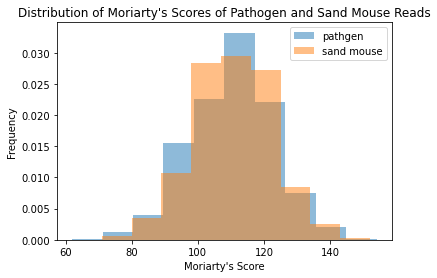

In [63]:
# Plot the histograms of frequency of scores for both sets of sequences
plt.hist(path_scores,density=True,alpha=0.5, label="pathgen")
plt.hist(sandmouse_scores,density=True,alpha=0.5, label="sand mouse")
plt.title("Distribution of Moriarty's Scores of Pathogen and Sand Mouse Reads")
plt.legend()
plt.xlabel("Moriarty's Score")
plt.ylabel("Frequency")

We can see that the distributions of pathogen sequences scores and sand mouse sequence scores overlay heavily, suggesting that Moriarty's score can hardly serve as a metric to distinguish the two data sets.

To plot out the ROC curve, we first need to use different threshold values to collect as many pairs of sensitivity values and false positive rate values as possible.

In [64]:
def thresholding(t, hypo):
    """
    Use the given threshold t to count how many positive hypotheses and negative hypotheses from all given hypotheses
    :param t: a numeric threshold
    :param hypo: a list of scores
    :return: a count for positive hypotheses, a count for negative hypotheses
    """
    pos = 0
    neg = 0
    for h in hypo:
        if h > t:
            pos += 1
        else:
            neg += 1
    return pos, neg

def calc_roc(h1, h2, gap=1):
    """
    Calculate the sensitivity and false positive rate from given the scores from the two hypotheses H1 and H2, where H2 are the true null hypotheses
    :param h1: a list of scores from non-null hypotheses
    :param h2: a list of scores from null hypotheses
    :param gap: a integer value for the inverse of stepping the threshold values
    :return: a float representing the sensitivity, a float representing the false positive rate
    """
    rmax = int(np.ceil(max(max(h1), max(h2))))
    rmin = int(np.floor(min(min(h1), min(h2))))
    t_count = len(h1)
    n_count = len(h2)
    sens = []
    false_pos = []
    for r in range(rmin*gap, rmax*gap+1, 1):
        t = r/gap
        tp, fn = thresholding(t, h1)
        fp, tn = thresholding(t, h2)
        sens.append(tp/t_count)
        false_pos.append(fp/n_count)
    return sens, false_pos

In [65]:
# Calculate the sensitivity and false positive rate from pathogen and sandmouse Moriarty's scores
sensitivity_m, false_positive_rate_m = calc_roc(path_scores, sandmouse_scores,10)

Then, we are able to simulate the actual ROC plot with the collected values.

Text(0, 0.5, 'Sensitivity')

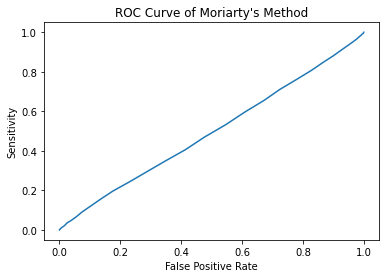

In [66]:
# Plotting the roc curve of Moriarty's method
plt.plot(false_positive_rate_m, sensitivity_m)
plt.title("ROC Curve of Moriarty's Method")
plt.xlabel("False Positive Rate")
plt.ylabel("Sensitivity")

## Analysis
We can see that by comparing the score distributions of the pathogen reads and sand mouse reads, Moriarty's method does not do a good job in distinguishing the groups. The ROC curve further proves the claim, where Moriarty's method is approximatedly random guessing. The results are different because Moriarty uses randomly constructed gene sequences with the same probability of occurrence for each of the nucleotides. Each individual nucleotide is generated independently. Therefore, $$\mathbb{E}[M(S)] = \mathbb{E}[S.count(A)]+\mathbb{E}[S.count(T)]-\mathbb{E}[S.count(G)]-\mathbb{E}[S.count(C)],$$ which is equal to $$len(S) \mathbb{P}(A) + len(S) \mathbb{P}(T) -len(S) \mathbb{P}(G)-len(S) \mathbb{P}(C) $$
$$= len(S)(\mathbb{P}(A)+\mathbb{P}(T)-\mathbb{P}(G)-\mathbb{P}(C)) = len(S)\times 0 = 0$$
Therefore, the distribution of scores of randomly generated sequences should be centered at 0. However, for the real sequences, the distribution of nucleotides in the sequence might not be independent and might not be random. Therefore, real sequence reads will not be completely unbiased in nucleotide counts. My results are obtained using actual sandmouse sequences, which is also affected by the bias of nucleotide counts. Therefore, as nucleotide counts bias is not a distinguishable feature of pathogen reads and normal reads, Moriarty's method does not work.

# Exercise 2: Second Order Markov Model
Since Moriarty's method does not account for the classification of the pathogen reads and normal sand mouse reads, we will implement a second order Markov model to attempt to classify the reads. Using the second order Markov model, we can express the probability of a read $S = x_1x_2x_3...x_L$ appearing as $$\mathbb{P}(x_1x_2x_3...x_L) = \mathbb{P}(x_1x_2)\prod_{i=3}^{L}\mathbb{P}(x_i|x_{i-2}x_{i-1})$$

In [67]:
def second_order_markov(seq, two_mer_probs, cond_probs):
    """
    An implementation of the second order markov model by calculating the probability of seq occurs given the model consisting of two mer probabilties and conditional probabilities
    :param seq: a string representing the input sequence
    :param two_mer_probs: a dictionary with keys representing every possible two mers and values representing the probability of occurrence of the key two mer
    :param cond_probs: a dictionary with keys representing each nucleotide and values of dictionaries of keys as two mers and values as probabilities of each two mer occurs as the preceeding two mer of the nucleotide
    :return: a float value of probability of occurrence of seq by the second order markov model
    """
    if len(seq) == 0:
        return 1
    elif len(seq) == 1:
        return 0.25
    else:
        init = two_mer_probs[seq[:2]]
        for i in range(2,len(seq)):
            prec = seq[i-2:i]
            init *= cond_probs[seq[i]][prec]
        return init

We also need to obtain the paramters (probabilities and conditional probabilities of models) from the training data. How this is done is by calculating the frequencies of each two mer and the frequencies of each two mer as a preceding two mer of each nucleotide.

In [68]:
def get_two_mer_probs(seqs, nucs = ["A","G","T","C"]):
    """
    Calculate the probabilities of occurrences of each two mer with the given sequences
    :param seqs: a list of strings representing the sequences
    :param nucs: a list of nucleotides that would appear in sequences
    :return: a dictionary with keys representing every possible two mers and values representing the probability of occurrence of the key two mer
    """
    probs = {}
    total = 0
    for n1 in nucs:
        for n2 in nucs:
            probs[n1+n2] = 0
    for seq in seqs:
        for i in range(len(seq)-1):
            total += 1
            probs[seq[i:i+2]] += 1
    for two_mer in probs.keys():
        probs[two_mer] /= total
    return probs

def get_two_mer_cond_probs(seqs, nucs = ["A","G","T","C"]):
    """
    Calculating the conditional probabilities of each nucleotide follows all possible preceeding two mers
    :param seqs: a list of strings representing the sequences
    :param nucs: a list of nucleotides that would appear in sequences
    :return: a dictionary with keys representing each nucleotide and values of dictionaries of keys as two mers and values as probabilities of each two mer occurs as the preceeding two mer of the nucleotide
    """
    probs = {}
    total = {}
    for n in nucs:
        total[n] = 0
        probs[n] = {}
        for n1 in nucs:
            for n2 in nucs:
                probs[n][n1+n2] = 0
    for seq in seqs:
        for i in range(2,len(seq)):
            nuc = seq[i]
            prec = seq[i-2:i]
            total[nuc] += 1
            probs[nuc][prec] += 1
    for nuc in nucs:
        for two_mer in probs[nuc].keys():
            probs[nuc][two_mer] /= total[nuc]

    return probs
 

Now we have all parameters for calculating the probability. We just need to preprocess the data for training and testing.

In [69]:
def split_train(seqs, splits = 2):
    """
    Split the input sequences to a train dataset and a test dataset where the size of the train dataset is the total number of sequences divided by splits
    :param seqs: a list of strings representing sequences
    :param splits: the fold of seqs and train data
    :return: a list of training sequences of size len(seqs)-len(seqs)//splits, a list of test sequences of size len(seqs)//splits
    """
    test_size = len(seqs) // splits
    rand_idx = np.random.permutation(len(seqs))
    test_idx = rand_idx[:test_size]
    train_idx = rand_idx[test_size:]
    train_seqs = [seqs[i] for i in train_idx]
    test_seqs = [seqs[i] for i in test_idx]
    return train_seqs, test_seqs

To calculate the log odds scores, we need all trained probabilities parameters and simply compute it with the probabilities for each model.

In [70]:
def log_odds_score(seq, mod_prob_1, mod_cond_1, mod_prob_2, mod_cond_2):
    """
    Calculate the log odds score for the given sequences using the probabilities obtained from the two models
    :param seq: a string representing the sequence
    :param mod_prob_1: a dictionary with keys representing every possible two mers and values representing the probability of occurrence of the key two mer for model 1
    :param mod_cond_1: a dictionary with keys representing each nucleotide and values of dictionaries of keys as two mers and values as probabilities of each two mer occurs as the preceeding two mer of the nucleotide for model 1
    :param mod_prob_2: a dictionary with keys representing every possible two mers and values representing the probability of occurrence of the key two mer for model 2
    :param mod_cond_2: a dictionary with keys representing each nucleotide and values of dictionaries of keys as two mers and values as probabilities of each two mer occurs as the preceeding two mer of the nucleotide for model 2
    :return: a float of log odds ratio of the sequence for the two models
    """
    prob_1 = second_order_markov(seq, mod_prob_1, mod_cond_1)
    prob_2 = second_order_markov(seq, mod_prob_2, mod_cond_2)
    return np.log(prob_1/prob_2)    

In [71]:
# Training the models and obtain the required probabilities
train_path_seqs, test_path_seqs = split_train(path_seqs)
train_sm_seqs, test_sm_seqs = split_train(sandmouse_seqs)
path_prob = get_two_mer_probs(train_path_seqs)
path_cond = get_two_mer_cond_probs(train_path_seqs)
sm_prob = get_two_mer_probs(train_sm_seqs)
sm_cond = get_two_mer_cond_probs(train_sm_seqs)

# Calculating the log odds scores for each sequences
path_log_odds_scores = []
sm_log_odds_scores = []
for seq in test_path_seqs:
    llr = log_odds_score(seq, path_prob, path_cond, sm_prob, sm_cond)
    path_log_odds_scores.append(llr)
for seq in test_sm_seqs:
    llr = log_odds_score(seq, path_prob,path_cond,sm_prob,sm_cond)
    sm_log_odds_scores.append(llr)

Then, we are able to plot the log odds ratios of each group of reads and draw the ROC curve.

Text(0, 0.5, 'Frequency')

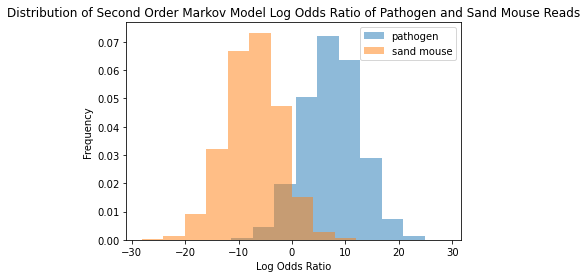

In [72]:
# Plots a histogram of frequencies of log odds scores
plt.hist(path_log_odds_scores, alpha=0.5, density=True, label="pathogen")
plt.hist(sm_log_odds_scores, alpha=0.5,density=True, label="sand mouse")
plt.title("Distribution of Second Order Markov Model Log Odds Ratio of Pathogen and Sand Mouse Reads")
plt.legend()
plt.xlabel("Log Odds Ratio")
plt.ylabel("Frequency")

In [73]:
# Calculate the sensitivity and false positive rate of the second order Markov model
sensitivity, false_positive_rate = calc_roc(path_log_odds_scores,sm_log_odds_scores,10)

Text(0, 0.5, 'Sensitivity')

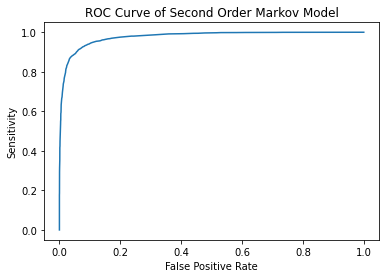

In [74]:
# Plot the ROC curve of the second order Markov model
plt.plot(false_positive_rate, sensitivity)
plt.title("ROC Curve of Second Order Markov Model")
plt.xlabel("False Positive Rate")
plt.ylabel("Sensitivity")

## Analysis
Apparently, my model works much better than Moriarty's method as we can clearly see the distributions of log odds ratios of the pathogen reads and normal sand mouse reads differs substantially and ROC curve shows a high sensitivity can be acheived with a low false positive rate at the same time. The reason behind this might be that by using the second order Markov model, we were able to take the order of nucleotides into account of our analysis. Since DNA sequences are transcribed into mRNA and mRNA are later translated into aminoacids by mapping three nucleotides into one amino acid. Therefore, the order of nucleotide matters in real RNA and it determines how DNA are expressed. Therefore, since pathogen reads should express differently with the normal cell sequences does, the nucleotide sequence order should be different to some extent as well. 

# Exercise 3: Evaluation of the Model
To find a threshold that can achieve the target sensitivity of 90%, we start by using the maximum possible threshold value and gradually decrease to see if the sensitivity is above the target.

In [75]:
def find_threshold(h1, h2, target_sensitivity=0.9, gap=1):
    """
    Finding the max threshold that acheives the target sensitivity from the scores of both hypotheses
    :param h1: a list of scores from non-null hypotheses
    :param h2: a list of scores from null hypotheses
    :param target_sensiticity: a numeric value between 0 and 1 representing the target sensitivity we want to achieve
    :param gap: a numeric value for stepping the threshold values
    :return: None if no such threshold exits, or the threshold value, true postive counts, false negative counts, false positive counts, true negative counts
    """
    rmax = int(np.ceil(max(max(h1), max(h2))))
    rmin = int(np.floor(min(min(h1), min(h2))))
    t_count = len(h1)
    n_count = len(h2)
    for r in range(rmax, rmin-1, -gap):
        tp, fn = thresholding(r, h1)
        fp, tn = thresholding(r, h2)
        if tp/t_count > target_sensitivity:
            return r, tp,fn,fp,tn
    return None

Since we know that the actual pathogen reads are only 1% of the reads obtains and mixed with 99% of sandmouse sequences, we would estimate that the actual false discover rate with the formula: $$\text{FDR} = \dfrac{\text{False Positives}}{\text{False Positives}+\text{True Positives}} = \dfrac{\text{\#\{Sand Mouse Reads Classified as Pathogen\}}\times 0.99}{\text{\#\{Sand Mouse Reads Classified as Pathogen\}}\times 0.99+\text{\#\{Pathogen Reads Classified as Pathogen\}}\times 0.01}$$

In [76]:
path_prop, sm_prop = 0.01, 0.99
thres_info = find_threshold(path_log_odds_scores, sm_log_odds_scores)
if thres_info is not None:
    print(thres_info)
    t, tp,fm,fp,tn = thres_info
    print("The score threshold would be %0.2f."%t)
    print("The estimated false positive rate would be %0.4f."%(fp/(tn+fp)))
    print("The false discovery rate is %0.4f." % (fp*sm_prop/(tp*path_prop+fp*sm_prop)))

(0, 4607, 392, 366, 4633)
The score threshold would be 0.00.
The estimated false positive rate would be 0.0732.
The false discovery rate is 0.8872.


Therefore, a threshold reaching the target sensitivity would be at 0 with false positive rate of 7%. With this threshold, we have obtained a FDR of 88.6%. which is very high. In this case, the model does not seems to be very good. However, if we take into account how rare the pathogen sequences appears comparing to normal sequences, the total number of reads identified as pathogen is not high, which is acceptable. We can also assume that the pathogen reads are not evenly distributed in the reads we identified as positive and negative, so the expected false discovery rate might not be the actual false discovery rate, suggesting the model is not as bad as it seems with the high FDR.